# Example: reproducing Feldman-Cousins

Jelle, April 2023

[Feldman & Cousins](https://arxiv.org/abs/physics/9711021) introduced confidence intervals based on the likelihood ratio test statistic

$\displaystyle \frac{L(\text{hypothesis})}{L(\text{best-fit hypothesis})}$

to the physics community. The technique itself dates back to Neyman & Pearson, 1925 (Kendall & Stuart chapter 22, section 1).

As one of their examples, Feldman & Cousins consider a "counting experiment with background". That is, an experiment with a known background expectation $b$ that counts the number of observed events $n$ to constrain an additional signal $\mu$.

The discretness of $n$ means that the set of allowed $\mu$ values for a given $n$ is not always simply connected. To derive confidence intervals, the natural solution is to quote the lowest and highest allowed hypotheses as the confidence interval, accepting some overcoverage from adding extra hypotheses in between.

Next, they note:

    "We find an additional mild pathology, again caused by the discreteness in n: when we compare the results for different values of b for fixed n, the upper endpoint μ2 is not always a decreasing function of b, as would be expected. When this happens, we force the function to be non-increasing, by lengthening selected confidence intervals as necessary."

Concretely, this means F&D quote the highest upper limit from a set of Neyman constructions for values of b at and below the actual b.

I am not aware of any applications of this in situations beyond the single-bin counting experiment. Such a scan over background expectations is also not well-defined for experiments that have multiple distinct and possibly uncertain backgrounds.

Below, we will reproduce the Feldman & Cousins tables of confidence intervals for a counting experiment, including this "compensation" for the "additional mild pathology". We see that the compensation is
  * Small, adding at most ~0.4 events to the upper limit for signal sizes < 15 events.
  * only occurs if fewer events are seen than expected from the background.


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import nafi
from nafi.likelihoods import counting

mu_sig = np.arange(0, 41, 0.005)
# Feldman & Cousins scanned with 0.001 precision in mu_bgs,
# feel free to adjust this here.
mu_bgs = np.arange(0, 16, 0.005)

n_max = 60
n_ns = n_max + 1
n_range = np.arange(n_ns)

uls = np.zeros((len(mu_bgs), n_ns))
uls_fc = np.zeros_like(uls)
lls = np.zeros_like(uls)

for bg_i, mu_bg in enumerate(tqdm(mu_bgs)):
    lnl, weights = counting.lnl_and_weights(mu_sig=mu_sig, mu_bg=mu_bg, n_max=n_max)
    ts, ps = nafi.ts_and_pvals(lnl, weights)
    ll, ul = nafi.intervals(ps, mu_sig, cl=0.9)
    uls[bg_i] = ul[:n_ns]
    lls[bg_i] = ll[:n_ns]

# The correction:
# If a lower background gives a higher upper limit, use that instead.
uls_fc = np.maximum.accumulate(uls[::-1,:], axis=0)[::-1,:]

100%|███████████████████████████████████████████████████████████| 3200/3200 [00:13<00:00, 242.45it/s]


This shows the limits for n = 0. The effect of Feldman & Cousins's correction is to bridge the valleys in the limit vs. background curve:

Text(0, 0.5, 'Upper limit for $n=0$ observed events')

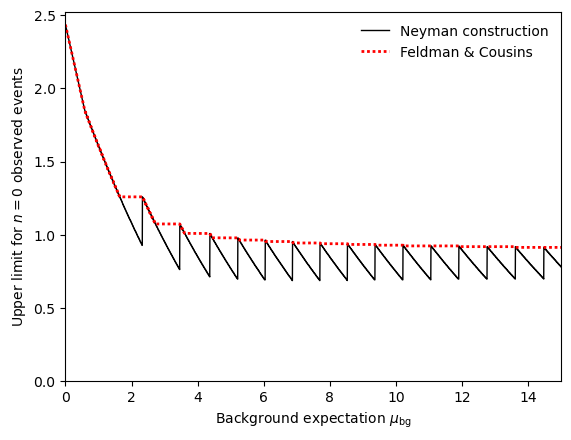

In [2]:
n_obs = 0
plt.plot(mu_bgs, uls[:,n_obs], c='k', label='Neyman construction', linewidth=1)
plt.plot(mu_bgs, uls_fc[:,n_obs], c='r', label='Feldman & Cousins', linewidth=2, dashes=(1,1))
plt.xlim(0, 15)
plt.ylim(0, None)
plt.legend(loc='upper right', frameon=False)
plt.xlabel("Background expectation $\mu_\mathrm{bg}$")
plt.ylabel(f"Upper limit for $n={n_obs}$ observed events")

We can also show the differences in the upper limits in a 2D (background, observation) plot:

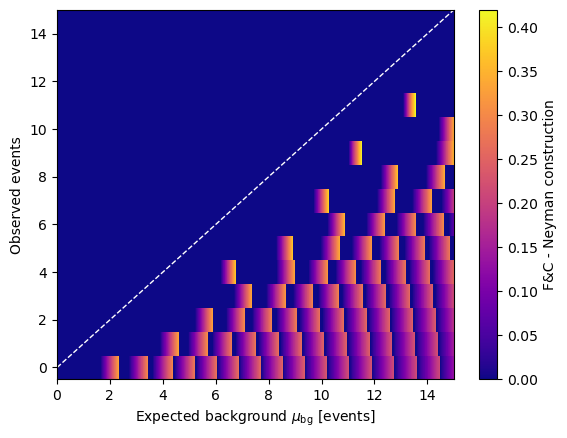

In [3]:
plt.pcolormesh(mu_bgs, n_range, (uls_fc - uls).T, cmap=plt.cm.plasma)
plt.colorbar(label="F&C - Neyman construction")
plt.xlabel("Expected background $\mu_\mathrm{bg}$ [events]")
plt.ylabel("Observed events")
plt.ylim(-0.5, 15)
plt.xlim(0, 15)
plt.plot([0, 15], [0, 15], c='white', linewidth=1, linestyle='--')

With this correction, we reproduce Feldman & Cousins' upper limits: compare table IV on page 37.

In [4]:
show_bgs = np.arange(0, 5.1, 0.5)
show_bg_is = np.argmin(np.abs(mu_bgs[None,:] - show_bgs[:,None]), axis=1)
show_bg_is

pd.DataFrame(
    uls_fc[show_bg_is, :21].round(2).T,
    columns=[f'b={b:.1g}' for b in show_bgs],
    index=[f'n={n}' for n in range(21)])

,b=0,b=0.5,b=1,b=2,b=2,b=2,b=3,b=4,b=4,b=4,b=5
n=0,2.44,1.94,1.61,1.33,1.26,1.18,1.08,1.06,1.01,0.98,0.98
n=1,4.36,3.86,3.36,2.91,2.53,2.19,1.88,1.59,1.39,1.39,1.22
n=2,5.91,5.41,4.91,4.41,3.91,3.45,3.04,2.67,2.33,2.02,1.73
n=3,7.42,6.92,6.42,5.92,5.42,4.92,4.42,3.95,3.53,3.14,2.78
n=4,8.60,8.10,7.60,7.10,6.60,6.10,5.60,5.10,4.60,4.10,3.60
n=5,9.99,9.49,8.99,8.49,7.99,7.49,6.99,6.49,5.99,5.49,4.99
n=6,11.47,10.97,10.47,9.97,9.47,8.97,8.47,7.97,7.47,6.97,6.47
n=7,12.53,12.03,11.53,11.03,10.53,10.03,9.53,9.03,8.53,8.03,7.53
n=8,13.99,13.49,12.99,12.49,11.99,11.49,10.99,10.49,9.99,9.49,8.99
n=9,15.30,14.80,14.30,13.80,13.30,12.80,12.30,11.80,11.30,10.80,10.30


The lower limits are left untouched in this "compensation"; compare the same table against these:

In [5]:
pd.DataFrame(
    lls[show_bg_is, :21].round(2).T,
    columns=[f'b={b:.1g}' for b in show_bgs],
    index=[f'n={n}' for n in range(21)])

,b=0,b=0.5,b=1,b=2,b=2,b=2,b=3,b=4,b=4,b=4,b=5
n=0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
n=1,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
n=2,0.53,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
n=3,1.10,0.60,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
n=4,1.47,1.17,0.74,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00
n=5,1.84,1.53,1.25,0.93,0.43,0.00,0.00,0.00,0.00,0.00,0.00
n=6,2.21,1.90,1.61,1.33,1.08,0.65,0.15,0.00,0.00,0.00,0.00
n=7,3.56,3.06,2.56,2.09,1.59,1.18,0.89,0.39,0.00,0.00,0.00
n=8,3.96,3.46,2.96,2.51,2.14,1.81,1.51,1.06,0.66,0.16,0.00
n=9,4.36,3.86,3.36,2.91,2.53,2.19,1.88,1.59,1.33,0.93,0.43
